In [38]:
# !pip install bcolz

In [39]:
# References
# - https://classroom.udacity.com/courses/ud188
# - https://jovian.ai/aakashns/05b-cifar10-resnet

# Imports
import os
import torch
import torchvision
import tarfile
import zipfile
import shutil
import json
import pickle
# import bcolz
import torch.nn as nn
import numpy as np
from string import punctuation
from collections import Counter
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchtext.vocab import Vocab
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams["figure.facecolor"] = "#ffffff"

In [40]:
# Extract from zip
# Train images
# with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/FYP/VQA_Reqog/Dataset/dataset_zips/train2014.zip', 'r') as zip_ref:
#    zip_ref.extractall('./')

# Val images
# with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/FYP/VQA_Reqog/Dataset/dataset_zips/val2014.zip', 'r') as zip_ref:
#    zip_ref.extractall('./')

In [41]:
# PARAMETERS
# IF CHANGING ANY PARAMETERS OR THE MODEL, CHANGE THE MODEL NAME FROM HERE AND NOTE IT IN THE EXCEL SHEET
# PROJECT_NAME = "reqog"

# 23 is the max length of the all the questions in the dataset
# SEQ_LENGTH = 25
# BATCH_SIZE = 2
# MODEL_NAME = "test-model"

In [42]:
# Custom VQA dataset class
class VQADataset(Dataset):
  size = None
  answer_type = None
  question_types = None
  num_of_output_classes = None
  train_json_annotations = None
  val_json_annotations = None
  ans_vocab_to_int = None
  vocab_to_int = None
  train_img_list = []
  val_img_list = []

  def __init__(self, dataset_type, size=None, answer_type=None, question_types=None, num_of_output_classes=None, transforms=None):
    if (answer_type is not None) and (num_of_output_classes is not None or size is not None):
      print("ERROR: Only one of the 3 filters can be used")
      return

    if (num_of_output_classes is not None) and (answer_type is not None or size is not None):
      print("ERROR: Only one of the 3 filters can be used")
      return

    if (size is not None) and (answer_type is not None or num_of_output_classes is not None):
      print("ERROR: Only one of the 3 filters can be used")
      return

    self.dataset_type = dataset_type
    VQADataset.size = size
    VQADataset.answer_type = answer_type
    VQADataset.question_types = question_types
    VQADataset.num_of_output_classes = num_of_output_classes
    self.transforms = transforms

    # Setting the file paths and the annotations file data
    self.root_dir = "./"

    # Train
    train_images_dir_path = self.root_dir + "train2014"
    train_annotations_file_path = self.root_dir + "drive/MyDrive/Colab Notebooks/FYP/VQA_Reqog/Dataset/train_data.json"
    VQADataset.train_img_list = os.listdir(train_images_dir_path)
    with open(train_annotations_file_path, "r") as openfile: 
      VQADataset.train_json_annotations = json.load(openfile)

    # Val
    val_images_dir_path = self.root_dir + "val2014"
    val_annotations_file_path = self.root_dir + "drive/MyDrive/Colab Notebooks/FYP/VQA_Reqog/Dataset/val_data.json"
    VQADataset.val_img_list = os.listdir(val_images_dir_path)
    with open(val_annotations_file_path, "r") as openfile: 
      VQADataset.val_json_annotations = json.load(openfile)

    # Main data for specific dataset types
    self.data = []

    # Filtering using the question_type (eg: "how many")
    if VQADataset.question_types is not None:
      train_data = []
      val_data = []
      for question in VQADataset.train_json_annotations:
        if question["question_type"] in VQADataset.question_types:
          train_data.append(question)

      for question in VQADataset.val_json_annotations:
        if question["question_type"] in VQADataset.question_types:
          val_data.append(question)
      
      VQADataset.train_json_annotations = train_data
      VQADataset.val_json_annotations = val_data

    # Filtering using the answer_type ("yes/no", "number", and "other")
    if VQADataset.answer_type is not None:
      train_data = []
      val_data = []
      for question in VQADataset.train_json_annotations:
        if question["answer_type"] == VQADataset.answer_type and question["answer_type"] == "yes/no":
          if question["answer"] == "yes" or question["answer"] == "no":
            train_data.append(question)  
        elif question["answer_type"] == VQADataset.answer_type:
          train_data.append(question)

      for question in VQADataset.val_json_annotations:
        if question["answer_type"] == VQADataset.answer_type and question["answer_type"] == "yes/no":
          if question["answer"] == "yes" or question["answer"] == "no":
            val_data.append(question)  
        elif question["answer_type"] == VQADataset.answer_type:
          val_data.append(question)
      
      VQADataset.train_json_annotations = train_data
      VQADataset.val_json_annotations = val_data

    # Filtering using the num_of_output_classes
    if VQADataset.num_of_output_classes is not None:
      train_data = []
      val_data = []
      train_answers = []
      for question in VQADataset.train_json_annotations:
        train_answers.append(question["answer"])

      most_common_n_answers = [word for word, word_count in Counter(train_answers).most_common(VQADataset.num_of_output_classes)]    
      
      for question in VQADataset.train_json_annotations:
        if question["answer"] in most_common_n_answers:
          train_data.append(question)

      for question in VQADataset.val_json_annotations:
        if question["answer"] in most_common_n_answers:
          val_data.append(question)  

      VQADataset.train_json_annotations = train_data
      VQADataset.val_json_annotations = val_data

    # Filtering using the size
    if VQADataset.size is not None:
      VQADataset.train_json_annotations = VQADataset.train_json_annotations[0:VQADataset.size]
      VQADataset.val_json_annotations = VQADataset.val_json_annotations[0:VQADataset.size]

    # Create the vocab for questions and answers
    # Adds the individual questions in the train set to the all_questions_list list
    all_questions_list = []
    all_answers_list = []
    for item in VQADataset.train_json_annotations:
      all_questions_list.append(" ".join(item["question"].split()))
      all_answers_list.append(item["answer"])

    for item in VQADataset.val_json_annotations:
      all_questions_list.append(" ".join(item["question"].split()))
      all_answers_list.append(item["answer"])

    # Joining all questions using a new line 
    all_questions_string_with_newline_separator = "\n".join(all_questions_list)

    # Converting all the text to lowecase
    all_questions_string_with_newline_separator = all_questions_string_with_newline_separator.lower()

    # Getting rid of punctuation
    all_text = "".join([char for char in all_questions_string_with_newline_separator if char not in punctuation])

    # Split by new lines
    questions_split = all_text.split("\n")

    # Joining each and every element in the list by a " " to make a 
    # single string that contains all the words from the question
    all_text = " ".join(questions_split)

    # Create a list of words
    words = all_text.split()

    # Encoding the words of questions and answers
    # Build a dictionary that maps words to integers
    counts = Counter(words)
    ans_counts = Counter(all_answers_list)
    vocab = sorted(counts, key=counts.get, reverse=True)
    ans_vocab = sorted(ans_counts, key=ans_counts.get, reverse=True)
    VQADataset.vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
    VQADataset.ans_vocab_to_int = {word: ii for ii, word in enumerate(ans_vocab)}
    VQADataset.vocab_to_int = self.update_vocab_with_unknown_token()

    print("Q vocab:", VQADataset.vocab_to_int)
    print("A vocab:", VQADataset.ans_vocab_to_int)

    # Use the dict to tokenize each question in questions_split and answer
    # Store the tokenized questions in questions_ints and answers in answer_ints
    questions_ints = []
    answer_ints = []
    for question in questions_split:
      questions_ints.append([VQADataset.vocab_to_int[word] for word in question.split()])

    for answer in all_answers_list:
      answer_ints.append(VQADataset.ans_vocab_to_int[answer])

    # Outlier questions stats
    question_lens = Counter([len(x) for x in questions_ints])
    print("Zero length questions: {}".format(question_lens[0]))
    print("Maximum question length: {}".format(max(question_lens)))

    question_features = self.pad_features(questions_ints, seq_length=SEQ_LENGTH)

    # Test statements
    assert len(question_features)==len(questions_ints), "Your features should have as many rows as questions."
    assert len(question_features[0])==SEQ_LENGTH, "Each feature row should contain seq_length values."

    print("question features len:", len(question_features))
    print("answer ints len:", len(answer_ints))
    print("trainset len:", len(VQADataset.train_json_annotations))
    print("valset len:", len(VQADataset.val_json_annotations))

    # Take the question_features and answer_ints and add to the val and train _json_annotations list
    train_len = len(VQADataset.train_json_annotations)
    train_question_features, val_question_features = question_features[:train_len], question_features[train_len:]
    train_answer_ints, val_answer_ints = answer_ints[:train_len], answer_ints[train_len:]

    print("train_question_features len:", len(train_question_features))
    print("val_question_features len:", len(val_question_features))
    print("train_answer_ints len:", len(train_answer_ints))
    print("val_answer_ints len:", len(val_answer_ints))

    for i, item in enumerate(VQADataset.train_json_annotations):
      item["encoded_question"] = train_question_features[i]
      item["encoded_answer"] = train_answer_ints[i]

    for i, item in enumerate(VQADataset.val_json_annotations):
      item["encoded_question"] = val_question_features[i]
      item["encoded_answer"] = val_answer_ints[i]

    # Assigning the data variable based on the dataset_type
    valset, testset = self.split_list(VQADataset.val_json_annotations)
    if self.dataset_type == "Train":
      self.data = VQADataset.train_json_annotations
      self.img_dir = train_images_dir_path
    elif self.dataset_type == "Val":
      self.data = valset
      self.img_dir = val_images_dir_path
    elif self.dataset_type == "Test":
      self.data = testset
      self.img_dir = val_images_dir_path

  def split_list(self, a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]   

  def update_vocab_with_unknown_token(self):
    unknown_token = {'<unk>': 0}
    unknown_token.update(VQADataset.vocab_to_int)
    num = 1
    for key in unknown_token:
      unknown_token[key] = num
      num += 1

    return unknown_token

  def __getitem__(self, index):
    # Getting the featurized question
    individual_datapoint = self.data[index] 

    # Getting the featurized question
    featurized_question = individual_datapoint["encoded_question"]
    
    # Getting the image
    image_path = self.img_dir + "/" + individual_datapoint["img_filename"]
    image = Image.open(image_path).convert("RGB")

    # Getting the answers
    answer = individual_datapoint["encoded_answer"]

    # Transforming the image if transforms are specifed
    if self.transforms is not None:
      image = self.transforms(image)

    return featurized_question, image, answer

  def __len__(self):
    return len(self.data)

  def pad_features(self, questions_ints, seq_length):
    # Return features of questions_ints, where each question is padded with 0's 
    # or truncated to the input seq_length.
    
    # Getting the correct rows x cols shape
    features = np.zeros((len(questions_ints), seq_length), dtype=int)

    # For each question, I grab that question and add zeros to the start 
    # or truncate to the seq_length
    for i, row in enumerate(questions_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [43]:
# If the image doesn't look like the original it is probably 
# because of the transformations
# def show_example(question, image, answer, q_vocab, a_vocab):
#     plt.imshow(image.permute(1, 2, 0))

#     print("Encoded question:", question)
#     print(q_vocab)
#     decoded_q = ""
#     for word in question:
#       for w, num in q_vocab.items():
#         if word == num:
#           decoded_q += w + " "
#     print("Decoded question:", decoded_q)

#     print("Encoded ground truth answer:", answer)
#     print(a_vocab)
#     decoded_ans = ""
#     for ans, num in a_vocab.items():
#       if num == answer:
#         decoded_ans = ans
#     print("Decoded ground truth answer:", decoded_ans)

In [44]:
# d_means = [0.485, 0.456, 0.406]
# d_stds = [0.229, 0.224, 0.225]
# img_transforms = tt.Compose([tt.Resize((224, 224)),
#                                tt.ToTensor(),
#                                tt.Normalize(mean=d_means, std=d_stds)
#                                ])

# question_types = ["how many", "how many people are", "how many people are in"]

# # Filter data using parameters
# train_set = VQADataset(dataset_type="Train", size=10, transforms=img_transforms)
# val_set = VQADataset(dataset_type="Val", size=10, transforms=img_transforms)
# test_set = VQADataset(dataset_type="Test", size=10, transforms=img_transforms)

# print("Length of train set:", len(train_set))
# print("Length of val set:", len(val_set))
# print("Length of test set:", len(test_set))

In [45]:
# show_example(*test_set[0], VQADataset.vocab_to_int, VQADataset.ans_vocab_to_int)

In [46]:
# train_dataloader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
# val_dataloader = DataLoader(val_set, BATCH_SIZE*2, num_workers=2, pin_memory=True)
# test_dataloader = DataLoader(test_set, BATCH_SIZE*2, num_workers=2, pin_memory=True)

In [47]:
# Testing purpose
# for questions, images, answers in train_dataloader:
#   print(questions.shape)
#   print(images.shape)
#   print(answers.shape)
#   break

In [48]:
# def denormalize(images, means, stds):
#     means = torch.tensor(means).reshape(1, 3, 1, 1)
#     stds = torch.tensor(stds).reshape(1, 3, 1, 1)
#     return images * stds + means

# def show_batch(dataloader):
#     for questions, images, answers in dataloader:
#         fig, ax = plt.subplots(figsize=(12, 12))
#         ax.set_xticks([]); ax.set_yticks([])
#         denorm_images = denormalize(images, d_means, d_stds)

#         # make_grid(denorm_images[:64], nrow=8) max of 64 images in the 
#         # grid with 8 images in each row 
#         ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
#         break

In [49]:
# show_batch(train_dataloader)

In [50]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class VQABase(nn.Module):
    def training_step(self, batch):
        questions, images, answers = batch 
        
        # Generate predictions
        out = self(images, questions)                             
        
        # Calculate loss
        loss = F.cross_entropy(out, answers)           
        return loss
    
    def validation_step(self, batch):
        questions, images, answers = batch
        
        # Generate predictions
        out = self(images, questions)                 
        
        # Calculate loss
        loss = F.cross_entropy(out, answers)   
        
        # Calculate accuracy
        acc = accuracy(out, answers)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        
        # Combine losses
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        
        # Combine accuracies
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch: {}, last_lr: {:.5f}, training_loss: {:.4f}, validation_loss: {:.4f}, validation_accuracy: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [51]:
# Creates the embedding layer with GloVe embeddings
def create_emb_layer(weights_matrix, non_trainable=False):
  num_embeddings, embedding_dim = weights_matrix.shape
  emb_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
  emb_layer.load_state_dict({'weight': torch.Tensor(weights_matrix)})
  if non_trainable:
      emb_layer.weight.requires_grad = False

  return emb_layer, num_embeddings, embedding_dim

class VQAModel(VQABase):
  def __init__(self, num_classes, weights_matrix):
    super(VQAModel, self).__init__()

    # Image
    # Get the pretrained resnet model
    resnet152 = models.resnet152(pretrained=True)

    # Remove the final fully connected layers to get only the convolutional 
    # feature extraction part of the CNN(ResNet)
    modules = list(resnet152.children())[:-1]
    resnet152 = nn.Sequential(*modules)

    # Fix the parameters of the feature extractor so that when training the 
    # gradients do not get calculated and therefore no saving memory
    for p in resnet152.parameters():
      p.requires_grad = False

    resnet152.add_module("flatten", nn.Flatten())
    resnet152.add_module("relu", nn.ReLU())

    self.image_feature_extractor = resnet152

    # Question
    self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=512, num_layers=2, batch_first=True)
    self.lstm_fc = nn.Linear(512, 2048)
    self.dropout = nn.Dropout(0.2)
    print("Num classes:", num_classes)
    self.classifier = nn.Linear(2048, num_classes)

  def forward(self, enc_img, enc_q):
    img_feats = self.image_feature_extractor(enc_img)
    
    embeddings = self.embedding(enc_q)
    embeddings = self.dropout(embeddings)
    q_out, (ht, ct) = self.lstm(embeddings)

    final_pred = torch.mul(img_feats, self.lstm_fc(ht[-1]))
    final_pred = self.classifier(final_pred)

    return final_pred

In [52]:
def get_default_device():

    # Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):

    # Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
  
    # Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    # Yield a batch of data after moving it to device
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    # Number of batches
    def __len__(self):
        return len(self.dl)

In [53]:
device = get_default_device()
device

device(type='cpu')

In [54]:
# train_dataloader = DeviceDataLoader(train_dataloader, device)
# val_dataloader = DeviceDataLoader(val_dataloader, device)
# test_dataloader = DeviceDataLoader(test_dataloader, device)

In [55]:
# Creating the GloVe embeddings
# glove_path = '/content/drive/MyDrive/Colab Notebooks/FYP/VQA_Reqog/GloVe'

# vectors = bcolz.open(f'{glove_path}/6B.300.dat')[:]
# words = pickle.load(open(f'{glove_path}/6B.300_words.pkl', 'rb'))
# word2idx = pickle.load(open(f'{glove_path}/6B.300_idx.pkl', 'rb'))

# glove = {w: vectors[word2idx[w]] for w in words}

# matrix_len = len(VQADataset.vocab_to_int) + 1
# weights_matrix = np.zeros((matrix_len, 300))
# words_found = 0

# for i, word in enumerate(VQADataset.vocab_to_int):
#     try: 
#         weights_matrix[i + 1] = glove[word]
#         words_found += 1
#     except KeyError:
#         weights_matrix[i + 1] = np.random.normal(scale=0.6, size=(300, ))

# weights_matrix[1] = pickle.load(open(f'{glove_path}/unk_embeddings_list.pkl', 'rb'))
# print("Total length of vocab:", matrix_len)
# print("Words found:", words_found)

In [56]:
# model = to_device(VQAModel(len(VQADataset.ans_vocab_to_int), weights_matrix), device)
# model

In [57]:
# @torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)

# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

# def fit_one_cycle(epochs, tot_epochs, model, history, train_loader, val_loader, 
#                   learning_rate_optimizer, one_cycle_scheduler, grad_clip=None):
#     torch.cuda.empty_cache()
    
#     for epoch in range(epochs):

#         # Training Phase 
#         model.train()
#         train_losses = []
#         lrs = []
#         for batch in train_loader:
#             loss = model.training_step(batch)
#             train_losses.append(loss)
#             loss.backward()
            
#             # Gradient clipping
#             if grad_clip: 
#                 nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
#             learning_rate_optimizer.step()
#             learning_rate_optimizer.zero_grad()
            
#             # Record & update learning rate
#             lrs.append(get_lr(learning_rate_optimizer))
#             one_cycle_scheduler.step()
        
#         # Validation phase
#         result = evaluate(model, val_loader)
#         result['train_loss'] = torch.stack(train_losses).mean().item()
#         result['lrs'] = lrs
#         model.epoch_end(epoch, result)
#         history.append(result)

#         # Saving the model
#         remaining_epochs = (epochs - (epoch + 1))
#         epoch_file_num = (tot_epochs - remaining_epochs)

#         # Save new model checkpoint
#         torch.save({
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': learning_rate_optimizer.state_dict(),
#             'sched_state_dict': one_cycle_scheduler.state_dict(),
#             'history': history,
#             'remaining_epochs': remaining_epochs
#             }, './drive/MyDrive/Colab Notebooks/FYP/Saved models/epoch_no_' + str(epoch_file_num) + '-' + MODEL_NAME + '.pth')
#     return history

In [58]:
# history = [evaluate(model, val_dataloader)]
# history

In [59]:
# evaluate(model, test_dataloader)

In [60]:
# print("Outputs before saving:", VQADataset.ans_vocab_to_int)
# print("Vocab before saving:", VQADataset.vocab_to_int)

# EPOCHS = 8
# MAX_LR = 0.01
# GRAD_CLIP = 0.1
# WEIGHT_DECAY = 1e-4
# opt_func = torch.optim.Adam

# # Set up cutom optimizer with weight decay
# learning_rate_optimizer = opt_func(model.parameters(), MAX_LR, weight_decay=WEIGHT_DECAY)

# # Set up one-cycle learning rate scheduler
# one_cycle_scheduler = torch.optim.lr_scheduler.OneCycleLR(learning_rate_optimizer, 
#                       MAX_LR, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))

# # Save model init checkpoint
# torch.save({
#             'model_structure': model,
#             'optimizer_structure': learning_rate_optimizer,
#             'sched_structure': one_cycle_scheduler,
#             'ans_vocab_to_int': VQADataset.ans_vocab_to_int,
#             'vocab_to_int': VQADataset.vocab_to_int,
#             'epochs': EPOCHS,
#             'max_lr': MAX_LR,
#             'weight_decay': WEIGHT_DECAY,
#             'grad_clip': GRAD_CLIP,
#             'opt_func': opt_func,
#             'history': history
#             }, './drive/MyDrive/Colab Notebooks/FYP/Saved models/init-' + MODEL_NAME + '.pth')

In [61]:
# %%time
# history = fit_one_cycle(epochs=EPOCHS, tot_epochs=EPOCHS, model=model, history=history, 
#                           train_loader=train_dataloader, val_loader=val_dataloader, 
#                           learning_rate_optimizer=learning_rate_optimizer, 
#                          one_cycle_scheduler=one_cycle_scheduler, grad_clip=GRAD_CLIP)

In [62]:
# Load from init checkpoint
# init_checkpoint = torch.load('./drive/MyDrive/Colab Notebooks/FYP/Saved models/init-' + MODEL_NAME + '.pth')
# init_model_structure = init_checkpoint['model_structure']
# init_optimizer_structure = init_checkpoint['optimizer_structure']
# init_sched_structure = init_checkpoint['sched_structure']
# init_ans_vocab_to_int = init_checkpoint['ans_vocab_to_int']
# init_vocab_to_int = init_checkpoint['vocab_to_int']
# init_epochs = init_checkpoint['epochs']
# init_max_lr = init_checkpoint['max_lr']
# init_weight_decay = init_checkpoint['weight_decay']
# init_grad_clip = init_checkpoint['grad_clip']
# init_opt_func = init_checkpoint['opt_func']
# init_history = init_checkpoint['history']

# # Load from last epoch checkpoint
# # Enter epoch number
# # last_checkpoint = torch.load('./drive/MyDrive/Colab Notebooks/FYP/Saved models/epoch_no_8-' + MODEL_NAME + '.pth')
# last_model_state_dict = last_checkpoint['model_state_dict']
# last_optimizer_state_dict = last_checkpoint['optimizer_state_dict']
# last_sched_state_dict = last_checkpoint['sched_state_dict']
# last_history = last_checkpoint['history']
# last_remaining_epochs = last_checkpoint['remaining_epochs']

# init_model_structure.load_state_dict(last_model_state_dict)
# init_optimizer_structure.load_state_dict(last_optimizer_state_dict)
# init_sched_structure.load_state_dict(last_sched_state_dict)

# if last_remaining_epochs == 0:
#   print("Already trained for the full amount of epochs")
# else:
#   print(last_remaining_epochs, "epoch(s) trainable, uncomment the below cell and run it!")

In [63]:
# %%time
# history = fit_one_cycle(epochs=last_remaining_epochs, tot_epochs=init_epochs, model=init_model_structure, history=last_history, 
#                           train_loader=train_dataloader, val_loader=val_dataloader, 
#                           learning_rate_optimizer=init_optimizer_structure, 
#                          one_cycle_scheduler=init_sched_structure, grad_clip=init_grad_clip)

In [64]:
# def plot_accuracies(history):
#     accuracies = [x['val_acc'] for x in history]
#     plt.plot(accuracies, '-x')
#     plt.xlabel('epoch')
#     plt.ylabel('accuracy')
#     plt.title('Accuracy vs. No. of epochs')

# def plot_losses(history):
#     train_losses = [x.get('train_loss') for x in history]
#     val_losses = [x['val_loss'] for x in history]
#     plt.plot(train_losses, '-bx')
#     plt.plot(val_losses, '-rx')
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.legend(['Training', 'Validation'])
#     plt.title('Loss vs. No. of epochs')

# def plot_lrs(history):
#     lrs = np.concatenate([x.get('lrs', []) for x in history])
#     plt.plot(lrs)
#     plt.xlabel('Batch no.')
#     plt.ylabel('Learning rate')
#     plt.title('Learning Rate vs. Batch no.')

In [65]:
# plot_accuracies(last_history)

In [66]:
# plot_losses(last_history)

In [67]:
# plot_lrs(last_history)

In [68]:
# question, img, answer = test_set[0]
# show_example(question, img, answer, init_vocab_to_int, init_ans_vocab_to_int)
# print()
# print('Predicted:', predict_image(question, img, init_model_structure))

## ------------------------------------------------------------

In [69]:
# Load from count model init checkpoint
init_count_checkpoint = torch.load('E:\Projects\Reqog (FYP) - backend\count_1.0-model\init-count_1.0-model.pth', map_location=torch.device('cpu'))
init_count_model_structure = init_count_checkpoint['model_structure']
init_count_ans_vocab_to_int = init_count_checkpoint['ans_vocab_to_int']
init_count_vocab_to_int = init_count_checkpoint['vocab_to_int']

# Load from last epoch count model checkpoint
# Enter epoch number
last_count_checkpoint = torch.load('E:\Projects\Reqog (FYP) - backend\count_1.0-model\epoch_no_8-count_1.0-model.pth', map_location=torch.device('cpu'))
last_count_model_state_dict = last_count_checkpoint['model_state_dict']
last_count_history = last_count_checkpoint['history']

init_count_model_structure.load_state_dict(last_count_model_state_dict)

# Load from general model init checkpoint
init_general_checkpoint = torch.load('E:\Projects\Reqog (FYP) - backend\count_1.0-model\init-count_1.0-model.pth', map_location=torch.device('cpu'))
init_general_model_structure = init_general_checkpoint['model_structure']
init_general_ans_vocab_to_int = init_general_checkpoint['ans_vocab_to_int']
init_general_vocab_to_int = init_general_checkpoint['vocab_to_int']

# Load from last epoch general model checkpoint
# Enter epoch number
last_general_checkpoint = torch.load('E:\Projects\Reqog (FYP) - backend\count_1.0-model\epoch_no_8-count_1.0-model.pth', map_location=torch.device('cpu'))
last_general_model_state_dict = last_general_checkpoint['model_state_dict']
last_general_history = last_general_checkpoint['history']

init_general_model_structure.load_state_dict(last_general_model_state_dict)

<All keys matched successfully>

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 16:27:40] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  2  8  4
 29]
Decoded question: how many people are here 
Predicted Answer: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 16:32:22] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   3   2 126   4  29]
Decoded question: how many laptops are here 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 16:32:55] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   3   2 558   4   9   5 551]
Decoded question: how many keys are on the laptop 
Predicted Answer: 25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 16:54:03] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
Decoded question: <unk> <unk> <unk> 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:01:10] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  2
 96]
Decoded question: how many bottles 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:06:47] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    1 2435   25    5 3200]
Decoded question: <unk> what is the question 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:07:10] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    1 2435   25    5 3200]
Decoded question: <unk> what is the question 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:11:59] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
Decoded question: <unk> <unk> <unk> 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:12:18] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
Decoded question: <unk> <unk> <unk> 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:16:11] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Decoded question: <unk> <unk> 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:16:23] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Decoded question: <unk> <unk> 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:21:33] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
Decoded question: <unk> <unk> <unk> 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:21:47] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
Decoded question: <unk> <unk> <unk> 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:24:16] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Decoded question: <unk> <unk> 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:24:43] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Decoded question: <unk> <unk> 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:37:48] "POST /get-prediction HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2021 17:37:48] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Encoded question:Decoded question:  <unk> <unk> 
Predicted Answer: 1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Decoded question: <unk> <unk> 
Predicted Answer: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
127.0.0.1 - - [22/Apr/2021 17:40:32] "POST /get-prediction HTTP/1.1" 200 -


Encoded question: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Decoded question: <unk> <unk> 
Predicted Answer: 1


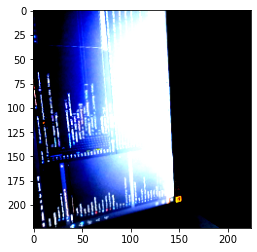

In [76]:
# from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify

# Running the flask app
app = Flask(__name__)

# Start ngrok when the app is run
# run_with_ngrok(app)

d_means = [0.485, 0.456, 0.406]
d_stds = [0.229, 0.224, 0.225]
img_transforms = tt.Compose([tt.Resize((224, 224)),
                               tt.ToTensor(),
                               tt.Normalize(mean=d_means, std=d_stds)
                               ])

def get_checkpoints(question):
    question.lower()
    question = "".join([char for char in question.lower() if char not in punctuation])
    question_split = question.split()
    if question_split[0] == "how" and question_split[1] == "many":
        return init_count_model_structure, init_count_vocab_to_int, init_count_ans_vocab_to_int
    else:
        return init_general_model_structure, init_general_vocab_to_int, init_general_ans_vocab_to_int

def predict_image(question, img, model, ans_vocab_to_int):

    # Convert to a batch of 1
    input_img = to_device(img.unsqueeze(0), device)
    input_question = to_device(torch.Tensor(question).to(torch.int64).unsqueeze(0), device)

    # Get predictions from model
    yb = model(input_img, input_question)

    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    
    # Retrieve the class label
    for answer, answer_int in ans_vocab_to_int.items():
      if answer_int == preds[0].item():
          return answer

def pad_features_backend(encoded_question, seq):
    # Return features of questions_ints, where each question is padded with 0's 
    # or truncated to the input seq_length.
    padded_encoded_question = np.zeros((1, seq), dtype=int)
    padded_encoded_question[0, -len(encoded_question):] = np.array(encoded_question)[:seq]
    return np.reshape(padded_encoded_question, (seq, ))

def show_example_backend(question, image, vocab_to_int):
    plt.imshow(image.permute(1, 2, 0))
    print("Encoded question:", question)
    decoded_q = ""
    for word in question:
      for w, num in vocab_to_int.items():
        if word == num:
          decoded_q += w + " "
    print("Decoded question:", decoded_q)

@app.route("/")
def index():
    return "<h1>Reqog</h1>"

@app.route("/get-prediction", methods=["POST"])
def get_data():
    img_file = request.files['image']
    question = request.form['question']

    # Read the image via file.stream
    img = Image.open(img_file.stream)
    img = img.convert('RGB')
    img = img_transforms(img)
    
    model, vocab_to_int, ans_vocab_to_int = get_checkpoints(question)

    question = "".join([char for char in question.lower() if char not in punctuation])
    
    question_split = question.split()
    new_question = []
    for word in question_split:
        if word in vocab_to_int.keys():
          new_question.append(word)
        else:
          new_question.append('<unk>')

    question_enc = [vocab_to_int[word] for word in new_question]

    # Change the sequence length according to the model
    question_enc = pad_features_backend(question_enc, seq=25)
    answer = predict_image(question_enc, img, model, ans_vocab_to_int)
    show_example_backend(question_enc, img, vocab_to_int)
    print('Predicted Answer:', answer)

    return app.response_class(status=200, response=json.dumps(answer), mimetype='application/json')

app.run()